# Lecture 3 - Exercise notebook

### CQ1. (☆☆☆) Complete the following GAN code.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import os

from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from datasets import load_dataset

import torch.multiprocessing as mp
mp.set_start_method('fork', force=True)

/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CollateFn:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, batch):
        images = torch.stack([self.transform(item.pop("image")) for item in batch])
        return images, batch
    
class CelebADataModule(pl.LightningDataModule):
    def __init__(self, train_batch_size, val_batch_size, image_size):
        super().__init__()
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.image_size = image_size

    def setup(self, stage=None):
        dataset = load_dataset("tpremoli/CelebA-attrs")
        self.train_dataset = dataset["train"]
        self.val_dataset = dataset["validation"]

        train_transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.CenterCrop(self.image_size),
            transforms.RandomHorizontalFlip(),  # A bit of augmentation
            transforms.ToTensor(),
        ])
        self.train_collate_fn = CollateFn(train_transform)

        val_transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
        ])
        self.val_collate_fn = CollateFn(val_transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            shuffle=True,
            collate_fn=self.train_collate_fn,
            num_workers=16,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            shuffle=False,
            collate_fn=self.val_collate_fn,
            num_workers=16,
        )

In [ ]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, z_dim=128):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 1024 * 2 * 2)
        self.nn = nn.Sequential(
            *self.__get_decoder_block(1024, 512),  # 1024x2x2 -> 512x4x4
            *self.__get_decoder_block(512, 256),  # 512x4x4 -> 256x8x8
            *self.__get_decoder_block(256, 128),  # 256x8x8 -> 128x16x16
            *self.__get_decoder_block(128, 64),  # 128x16x16 -> 64x32x32
            *self.__get_decoder_block(64, 32),  # 64x32x32 -> 32x64x64
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),  # 16x64x64 -> 3x64x64
            nn.Sigmoid(),
        )

    def forward(self, z):
        x = self.fc1(z).view(-1, 1024, 2, 2)
        return self.nn(x)
    
    def __get_decoder_block(self, input_channels, output_channels):
        return [
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        ]

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.nn = nn.Sequential(
            *self.__get_encoder_block(3, 64),  # 3x64x64 -> 64x32x32
            *self.__get_encoder_block(64, 128),  # 64x32x32 -> 128x16x16
            *self.__get_encoder_block(128, 256),  # 128x16x16 -> 256x8x8
            *self.__get_encoder_block(256, 512),  # 256x8x8 -> 512x4x4
            *self.__get_encoder_block(512, 1024),  # 512x4x4 -> 1024x2x2
            nn.Flatten(),
            nn.Linear(1024 * 2 * 2, 1),
        )

    def forward(self, x):
        return self.nn(x)

    def __get_encoder_block(self, input_channels, output_channels):
        return [
            nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        ]

In [ ]:
class GANModule(pl.LightningModule):
    def __init__(self, opt_g_params, opt_d_params, z_dim=128):
        super(GANModule, self).__init__()
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.opt_g_params = opt_g_params
        self.opt_d_params = opt_d_params

        # NOTE: Disable automatic optimization to manually control the training loop
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        """
        Training step for the GAN module. We need to perform the optimization manually,
        so we disable the automatic optimization and implement the training loop ourselves.
        Each training loop consists of two steps:
            1. Train the discriminator
            2. Train the generator
        """
        # Get optimizers
        opt_D, opt_G = self.optimizers()

        # ================================================== #
        # ================== Prepare data ================== #
        # ================================================== #
        real_images, _ = batch  # [B, 3, 64, 64]
        z = torch.randn(real_images.size(0), self.z_dim).to(self.device)  # [B, z_dim]
        fake_images = self.generator(z)  # [B, 3, 64, 64]

        # ========================================================= #
        # ================== Train Discriminator ================== #
        # ========================================================= #
        opt_D.zero_grad()

        D_real = self.discriminator(real_images)
        D_fake = self.discriminator(fake_images.detach())  # NOTE: detach the fake_images tensor to avoid computing gradients for the generator
        loss_D = (
            F.binary_cross_entropy_with_logits(D_real, torch.ones_like(D_real)) +
            F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))
        )

        self.manual_backward(loss_D)
        opt_D.step()

        # ===================================================== #
        # ================== Train Generator ================== #
        # ===================================================== #
        opt_G.zero_grad()

        D_fake = self.discriminator(fake_images)
        # loss_G = -F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))  # NOTE: original GAN loss
        loss_G = F.binary_cross_entropy_with_logits(D_fake, torch.ones_like(D_fake))  # NOTE: non-saturating GAN loss

        self.manual_backward(loss_G)
        opt_G.step()

        # ================================================= #
        # ================== Log Results ================== #
        # ================================================= #
        self.log("loss_D", loss_D, on_step=True, on_epoch=False, prog_bar=True)
        self.log("loss_G", loss_G, on_step=True, on_epoch=False, prog_bar=True)

        return {"loss_D": loss_D, "loss_G": loss_G}

    def configure_optimizers(self):
        opt_D = optim.AdamW(self.discriminator.parameters(), **self.opt_d_params)
        opt_G = optim.AdamW(self.generator.parameters(), **self.opt_g_params)
        return [opt_D, opt_G], []
    
    def on_train_epoch_end(self):
        """
        Generate example images at the end of each epoch
        """
        os.makedirs("output/exercise1", exist_ok=True)
        file_path = f"output/exercise1/generator_epoch_{self.current_epoch}.png"
        z = torch.randn(64, self.z_dim).to(self.device)
        generated_images = self.generator(z)
        save_image(generated_images, file_path, nrow=8, normalize=True)
        return super().on_train_epoch_end()

In [ ]:
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
IMAGE_SIZE = 64

ZDIM = 128

OPT_G_PARAMS = {
    "lr": 1.5e-4,
    "betas": (0.5, 0.999),
}
OPT_D_PARAMS = {
    "lr": 1e-4,
    "betas": (0.5, 0.999),
}

In [ ]:
data_module = CelebADataModule(TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, IMAGE_SIZE)
data_module.setup()

/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
model = GANModule(OPT_G_PARAMS, OPT_D_PARAMS, ZDIM)
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices=[0])
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly u

Epoch 19: 100%|██████████| 2544/2544 [01:51<00:00, 22.88it/s, v_num=0, loss_D=0.00542, loss_G=6.440]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 2544/2544 [01:51<00:00, 22.76it/s, v_num=0, loss_D=0.00542, loss_G=6.440]


### CQ2. (☆☆☆☆☆) Modify the GAN code to make it a WGAN.

This was already done in the lecture notebook!

### CQ3. (☆☆☆☆) Modify the GAN code to make it a Conditional GAN.
You may use any dataset you want, as long as it has some attribute to condition the output! We use CIFAR-10 in the solution.

Again, we hide the answer because this is very similar to the assignment :)

### CQ4. (☆☆☆) Modify the GAN code by adding the Mode-Seeking loss from the slides.
In this exercise, we will change the GAN code to add the Mode-Seeking loss from the slides. Please complete the spaces in the code.

In [1]:
import torch
import pytorch_lightning as pl
import os
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

We will be working with synthetic data: we take the corners of a square and generate 2D points from a gaussian distribution around them.

[]

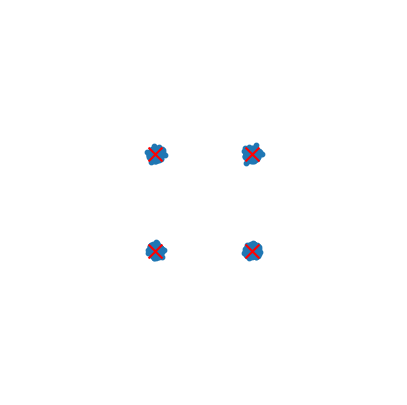

In [239]:
CENTERS = [ [1.0, 1.0], [1.0, -1.0], [-1.0, 1.0], [-1.0, -1.0] ]
STDS = [0.05, 0.05, 0.05, 0.05]

def generate_gaussian_data(n_samples_per_mode=500, centers=CENTERS, stds=STDS):
    data = []
    for center, std in zip(centers, stds):
        data.append(torch.randn(n_samples_per_mode, 2) * std + torch.tensor(center))
    return torch.cat(data, dim=0)

class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples_per_mode=500):
        self.data = generate_gaussian_data(n_samples_per_mode)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
class SyntheticDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = './data', batch_size: int = 64, n_samples_per_mode=500):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.n_samples_per_mode = n_samples_per_mode

    def setup(self, stage=None):
        self.train_dataset = SyntheticDataset(self.n_samples_per_mode)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)


# plot the ground truth data
data = generate_gaussian_data(1_000)
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], s=10)
for center in CENTERS:
    plt.scatter(center[0], center[1], s=100, marker="x", color="red")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axis('off')
plt.plot()

As you see, points are clustered around four points. These are different modes of the distribution. A GAN might end up collapsing on a few of them.

Let's now build the generator and discriminator. This is already done for you!

In [221]:
class Generator(nn.Module):
    def __init__(self, z_dim=4):
        super().__init__()
        self.ff_mlp = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 2),
        )

    def forward(self, z):
        return self.ff_mlp(z)
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff_mlp = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.ff_mlp(x)


Now we get to the GAN training module. Please complete the `__mode_seeking_loss` loss function!

In [222]:
class GANModule(pl.LightningModule):
    def __init__(self, opt_g_params, opt_d_params, z_dim=4, mode_seeking_loss_weight=0.1):
        super(GANModule, self).__init__()
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.opt_g_params = opt_g_params
        self.opt_d_params = opt_d_params
        self.mode_seeking_loss_weight = mode_seeking_loss_weight

        # NOTE: Disable automatic optimization to manually control the training loop
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        """
        Training step for the GAN module. We need to perform the optimization manually,
        so we disable the automatic optimization and implement the training loop ourselves.
        Each training loop consists of two steps:
            1. Train the discriminator
            2. Train the generator
        """
        # Get optimizers
        opt_D, opt_G = self.optimizers()

        # ================================================== #
        # ================== Prepare data ================== #
        # ================================================== #
        real_samples = batch  # [B, 2]
        z = self.__generate_noise(real_samples.size(0))  # [B, z_dim]
        fake_samples = self.generator(z)  # [B, 2]

        # ========================================================= #
        # ================== Train Discriminator ================== #
        # ========================================================= #
        opt_D.zero_grad()

        D_real = self.discriminator(real_samples)
        D_fake = self.discriminator(fake_samples.detach())  # NOTE: detach the fake_samples tensor to avoid computing gradients for the generator
        loss_D = (
            F.binary_cross_entropy_with_logits(D_real, torch.ones_like(D_real)) +
            F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))
        )

        self.manual_backward(loss_D)
        opt_D.step()

        # ===================================================== #
        # ================== Train Generator ================== #
        # ===================================================== #
        opt_G.zero_grad()

        D_fake = self.discriminator(fake_samples)
        # loss_G = -F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))  # NOTE: original GAN loss
        loss_G = F.binary_cross_entropy_with_logits(D_fake, torch.ones_like(D_fake))  # NOTE: non-saturating GAN loss
        mode_seeking_loss = self.__mode_seeking_loss(z, fake_samples)

        self.manual_backward(loss_G - self.mode_seeking_loss_weight * mode_seeking_loss)
        opt_G.step()

        # ================================================= #
        # ================== Log Results ================== #
        # ================================================= #
        self.log("loss_D", loss_D, on_step=True, on_epoch=False, prog_bar=True)
        self.log("loss_G", loss_G, on_step=True, on_epoch=False, prog_bar=True)
        self.log("mode_seeking_loss", mode_seeking_loss, on_step=True, on_epoch=False, prog_bar=True)

        return {"loss_D": loss_D, "loss_G": loss_G}
    
    def __generate_noise(self, n_samples):
        z_1 = torch.randn(n_samples, self.z_dim // 2).to(self.device)  # [B, z_dim]
        z_2 = torch.randint(0, 2, (n_samples, self.z_dim // 2)).float().to(self.device)  # [B, z_dim]
        return torch.cat((z_1, z_2), dim=1)
    
    def __mode_seeking_loss(self, z, x):
        # Compute the Euclidean distances between each pair of points
        z, x = z.flatten(1), x.flatten(1)

        z_norm_mat = torch.cdist(z, z, p=1)
        x_norm_mat = torch.cdist(x, x, p=1)
        
        return torch.mean(x_norm_mat / (z_norm_mat + 1e-6))

    def configure_optimizers(self):
        opt_D = optim.AdamW(self.discriminator.parameters(), **self.opt_d_params)
        opt_G = optim.AdamW(self.generator.parameters(), **self.opt_g_params)
        return [opt_D, opt_G], []
    
    def on_train_epoch_end(self):
        """
        Generate example samples at the end of each epoch
        """
        os.makedirs("output/mode_seeking_loss", exist_ok=True)
        file_path = f"output/mode_seeking_loss/generator_epoch_{self.current_epoch}.png"
        z = self.__generate_noise(1000)
        generated_samples = self.generator(z).detach().cpu().numpy()
        # plot 2D points in the range [-4, 4] x [-4, 4]
        plt.figure(figsize=(5, 5))
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=10)
        for center in CENTERS:
            plt.scatter(center[0], center[1], s=100, marker="x", color="red")
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.axis('off')
        plt.savefig(file_path)
        plt.close()
        return super().on_train_epoch_end()


You can now test the models with two different weights for the mode seeking loss. For me $1.5$ gave a good result, but depending on your implementation you might need to change the value. You can compare with a value of $0.0$ and see how the training dynamics change. In the `output_mode_seeking_loss` you will find the distribution produced by the generator after each epoch.

In [236]:
ZDIM = 8
OPT_G_PARAMS = { "lr": 1e-4, "weight_decay": 0.01 }
OPT_D_PARAMS = { "lr": 1e-4, "weight_decay": 0.01 }
BATCH_SIZE = 4
# MODE_SEEKING_LOSS_WEIGHT = 1.5
MODE_SEEKING_LOSS_WEIGHT = 0.0

In [240]:
data_module = SyntheticDataModule(batch_size=BATCH_SIZE)
data_module.setup()

In [238]:
model = GANModule(OPT_G_PARAMS, OPT_D_PARAMS, ZDIM, MODE_SEEKING_LOSS_WEIGHT)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices=[0])
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 50.9 K
1 | discriminator | Discriminator | 50.0 K
------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.404     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 500/500 [00:12<00:00, 39.68it/s, v_num=154, loss_D=0.957, loss_G=0.843, mode_seeking_loss=0.171]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 500/500 [00:12<00:00, 39.38it/s, v_num=154, loss_D=0.957, loss_G=0.843, mode_seeking_loss=0.171]


Some comments on the output (you can find it in `output/mode_seeking_loss*`):
- It might look like mode-seeking works much better because it didn't drop any mode, but it is a bit random depending on the run.
- Something that is more consistent is that it seems to degenerate less early on, converging earlier to a solution with some of the modes. But again, it really depends on the run. You can run multiple times and try to study the dynamics!



### CQ5. (☆☆☆☆☆) Modify the GAN code so that instead of generating images, the generator colours some input grayscale image
**NOTE**: This exercise is not guided, you will have to modify a good part of the code on your own.

Transform the GAN architecture so instead of generating images, the generator colors an input grayscaled image. Use the CIFAR-10 as dataset. Some hints:

- Use the Lab color space instead of RGB. The L channel is just the grayscale, and you just have to predict the "ab" channels. You will need to modify the data loading process to transform the images (using `skimage.color` for example).
- The generator is not a "decoder" now, from a small vector to a large image. It is now a full autoencoder.
- We recommend using a U-Net architecture. Basically, you take the output at each step of downsampling use it during upsampling. This way, in the center of the network you get the high level features, but do not lose the exact spatial features from early layers.

 ![u-net](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)
   
 The image and a more in-depth tutorial can be found [here](https://viso.ai/deep-learning/u-net-a-comprehensive-guide-to-its-architecture-and-applications/).

In [19]:
import torch
import pytorch_lightning as pl
import os

from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [20]:
class Cifar10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = './data', batch_size: int = 64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = CIFAR10(self.data_dir, train=True, download=True, transform=transforms.ToTensor())
        self.val_dataset = CIFAR10(self.data_dir, train=False, download=True, transform=transforms.ToTensor())

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

In [229]:
class UNetGenerator(nn.Module):
    """
    UNet Generator model for image coloring. Skip-connections are implemented as sums,
    but you can change them to concatenation if you prefer.
    """
    def __init__(self, latent_dim=256):
        super(UNetGenerator, self).__init__()

        # Encoder (Contracting path)
        self.enc1 = self.conv_block(1, 64)  # 1 input channel for L channel
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.enc5 = self.conv_block(512, 1024)
        
        # Latent space
        self.fc = nn.Linear(1024, latent_dim)
        self.fc_expand = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
        )

        # Decoder (Expanding path)
        self.dec1 = self.deconv_block(1024, 512)
        self.dec2 = self.deconv_block(512, 256)
        self.dec3 = self.deconv_block(256, 128)
        self.dec4 = self.deconv_block(128, 64)
        self.dec5 = self.deconv_block(64, 2)  # 2 output channels for AB channels

        self.out_conv = nn.Conv2d(2, 2, kernel_size=1, stride=1, padding=0)  # 1x1 convolution for color prediction
    
    def conv_block(self, in_channels, out_channels):
        """ Helper function for creating convolutional blocks """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def deconv_block(self, in_channels, out_channels):
        """ Helper function for creating deconvolutional (transposed conv) blocks """
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        batch_size = x.size(0)

        # Encoder forward pass
        enc1_out = self.enc1(x)
        enc2_out = self.enc2(enc1_out)
        enc3_out = self.enc3(enc2_out)
        enc4_out = self.enc4(enc3_out)
        enc5_out = self.enc5(enc4_out)
        
        # Flatten and pass through the latent space layers
        flattened = enc5_out.view(batch_size, -1)  # Flatten the output
        z = self.fc(flattened)
        
        # Expand the latent space and reshape for decoder
        z = self.fc_expand(z)
        
        # Decoder forward pass
        dec1_out = self.dec1(z.view(batch_size, 1024, 1, 1))  # Reshape z for decoder
        dec2_out = self.dec2(dec1_out + enc4_out)  # Skip connection from encoder
        dec3_out = self.dec3(dec2_out + enc3_out)
        dec4_out = self.dec4(dec3_out + enc2_out)
        dec5_out = self.dec5(dec4_out + enc1_out)

        # Final output
        x_hat = self.out_conv(dec5_out)
        
        return x_hat, z

In [21]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.nn = nn.Sequential(
            *self.__get_encoder_block(3, 32),   # 3x32x32 -> 32x16x16
            *self.__get_encoder_block(32, 64),  # 32x16x16 -> 64x8x8
            *self.__get_encoder_block(64, 128), # 64x8x8 -> 128x4x4
            *self.__get_encoder_block(128, 256),# 128x4x4 -> 256x2x2
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 1),
        )

    def forward(self, x):
        return self.nn(x)

    def __get_encoder_block(self, input_channels, output_channels):
        return [
            nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.GELU(),
        ]


In [22]:
class GANModule(pl.LightningModule):
    def __init__(self, opt_g_params, opt_d_params, z_dim=128):
        super(GANModule, self).__init__()
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.opt_g_params = opt_g_params
        self.opt_d_params = opt_d_params

        # NOTE: Disable automatic optimization to manually control the training loop
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        """
        Training step for the GAN module. We need to perform the optimization manually,
        so we disable the automatic optimization and implement the training loop ourselves.
        Each training loop consists of two steps:
            1. Train the discriminator
            2. Train the generator
        """
        # Get optimizers
        opt_D, opt_G = self.optimizers()

        # ================================================== #
        # ================== Prepare data ================== #
        # ================================================== #
        real_images, _ = batch  # [B, 3, 64, 64]
        z = torch.randn(real_images.size(0), self.z_dim).to(self.device)  # [B, z_dim]
        fake_images = self.generator(z)  # [B, 3, 64, 64]

        # ========================================================= #
        # ================== Train Discriminator ================== #
        # ========================================================= #
        opt_D.zero_grad()

        D_real = self.discriminator(real_images)
        D_fake = self.discriminator(fake_images.detach())  # NOTE: detach the fake_images tensor to avoid computing gradients for the generator
        loss_D = (
            F.binary_cross_entropy_with_logits(D_real, torch.ones_like(D_real)) +
            F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))
        )

        self.manual_backward(loss_D)
        opt_D.step()

        # ===================================================== #
        # ================== Train Generator ================== #
        # ===================================================== #
        opt_G.zero_grad()

        D_fake = self.discriminator(fake_images)
        # loss_G = -F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))  # NOTE: original GAN loss
        loss_G = F.binary_cross_entropy_with_logits(D_fake, torch.ones_like(D_fake))  # NOTE: non-saturating GAN loss

        self.manual_backward(loss_G)
        opt_G.step()

        # ================================================= #
        # ================== Log Results ================== #
        # ================================================= #
        self.log("loss_D", loss_D, on_step=True, on_epoch=False, prog_bar=True)
        self.log("loss_G", loss_G, on_step=True, on_epoch=False, prog_bar=True)

        return {"loss_D": loss_D, "loss_G": loss_G}

    def configure_optimizers(self):
        opt_D = optim.AdamW(self.discriminator.parameters(), **self.opt_d_params)
        opt_G = optim.AdamW(self.generator.parameters(), **self.opt_g_params)
        return [opt_D, opt_G], []
    
    def on_train_epoch_end(self):
        """
        Generate example images at the end of each epoch
        """
        os.makedirs("output/vanilla_cifar10", exist_ok=True)
        file_path = f"output/vanilla_cifar10/generator_epoch_{self.current_epoch}.png"
        z = torch.randn(64, self.z_dim).to(self.device)
        generated_images = self.generator(z)
        save_image(generated_images, file_path, nrow=8, normalize=True)
        return super().on_train_epoch_end()

In [23]:
ZDIM = 128
OPT_G_PARAMS = {
    "lr": 1.5e-4,
    "betas": (0.5, 0.999),
}
OPT_D_PARAMS = {
    "lr": 1e-4,
    "betas": (0.5, 0.999),
}
BATCH_SIZE = 256

In [24]:
data_module = Cifar10DataModule(batch_size=BATCH_SIZE)
data_module.setup()

Files already downloaded and verified
Files already downloaded and verified


In [25]:
model = GANModule(OPT_G_PARAMS, OPT_D_PARAMS, ZDIM)
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices=[0])
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.8 M 
1 | discriminator | Discriminator | 390 K 
------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.894     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 196/196 [00:07<00:00, 26.24it/s, v_num=75, loss_D=1.300, loss_G=0.896]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 196/196 [00:07<00:00, 25.37it/s, v_num=75, loss_D=1.300, loss_G=0.896]
